### Updated on 17-05-2021
<br>
This notebook implements the 3 party Quantum Conference protocol along with Intercept and Resend Attack

In [1]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plotter
import numpy as np
from IPython.display import display, Math, Latex, Image
import random
%matplotlib inline

Here all the conventions of 3 party QC parallel Notebook are followed

In [2]:
num_bits = 8

key_ini = np.random.randint(2, size = num_bits)

alice_mess_ini = np.random.randint(2, size = num_bits)
bob_mess_ini = np.random.randint(2, size = num_bits)
charlie_mess_ini = np.random.randint(2, size = num_bits)

delta_m = 2

common_idx = np.sort(np.random.choice(num_bits, size = delta_m, replace = False))

qa_ini = np.random.choice(num_bits, size = num_bits, replace = False)
qb_ini = np.random.choice(num_bits, size = num_bits, replace = False)
qc_ini = np.random.choice(num_bits, size = num_bits, replace = False)


In [3]:
def encode_message(key_bit, message_bit, qubit, circuit):
    if message_bit == 1:
        circuit.x(qubit)
    if key_bit == 1:
        circuit.h(qubit)
    return circuit

def run_circuit(qc, shot):
    backend = Aer.get_backend('qasm_simulator') 
    result = execute(qc, backend, shots = shot).result() 
    counts = result.get_counts()
    return counts

def count_to_str(counts):
    r = counts.items()
    for res, shots in r:
        result = str(res)
    return result

In [10]:

alice = QuantumRegister(num_bits, "alice")
bob = QuantumRegister(num_bits, "bob")
charlie = QuantumRegister(num_bits, "charlie")
ufp1 = ClassicalRegister(3*num_bits - 3*delta_m)
ufp2 = ClassicalRegister(3*delta_m)
eave = ClassicalRegister(3*num_bits, "eave")

circuit = QuantumCircuit(alice, bob, charlie, ufp1, ufp2, eave)

for i in range(num_bits):
    
    k = key_ini[i]
    a = alice_mess_ini[i]
    b = bob_mess_ini[i]
    c = charlie_mess_ini[i]
    
    a_idx = qa_ini[i]
    b_idx = qb_ini[i]
    c_idx = qc_ini[i]
        
    encode_message(k, a, alice[a_idx], circuit)
    encode_message(k, b, bob[b_idx], circuit)
    encode_message(k, c, charlie[c_idx], circuit)

circuit.barrier()

Now the Eaves dropper actions are depicted in the next cells. <br>
Here we will be executing the attack INTERCEPT and RESEND Attack, and will prove that the probability of correctly guessing the Eave's activity in the channel is <br>
P = 1 - $(3/4)^{3*detla_m}$

In [11]:
e = random.randint(0,1)
# Here eave = 1 means in the next step eave will be performing Attack and 0 means that eave will not

In [12]:
#Any Eaves Dropping actions will be implemented in this cell

eave_base = np.random.randint(2, size = num_bits)

for i in range(num_bits):
    
    b = eave_base[i]
    
    if b == 1:
        circuit.h([alice[i], bob[i], charlie[i]])
    
    circuit.measure([alice[i], bob[i], charlie[i]], [eave[3*i], eave[3*i+1], eave[3*i+2]])
    
#This above is the intercept and resend attack 
#Now eaves 

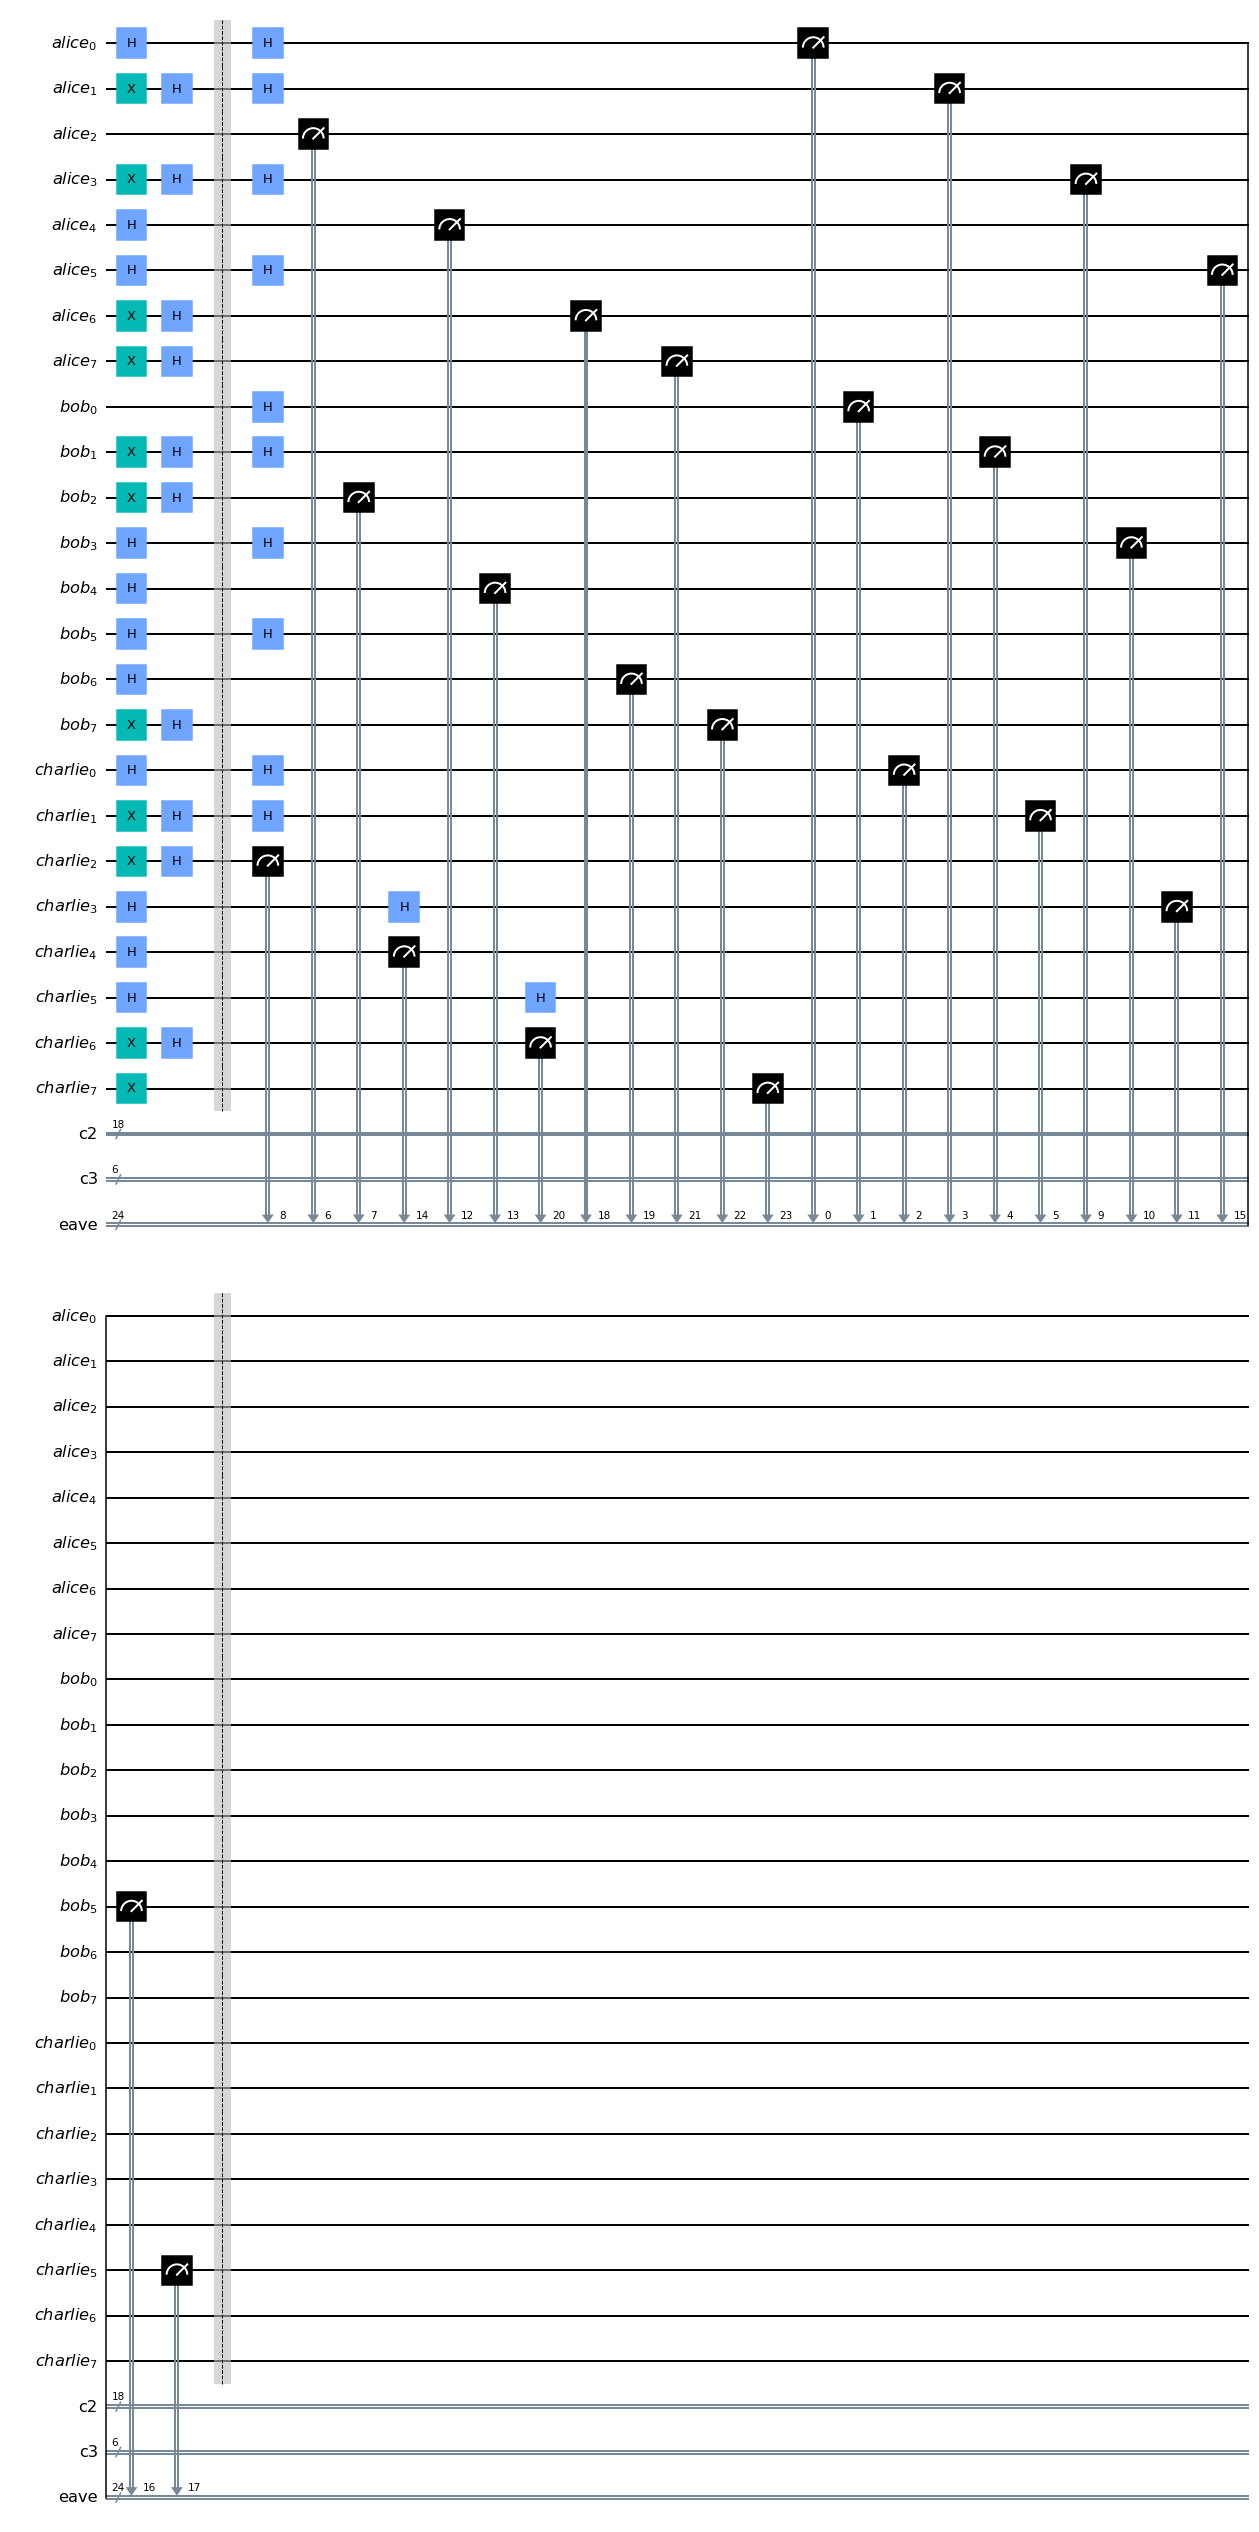

In [13]:
circuit.barrier()

circuit.draw(output = 'mpl')

000000000000000000 111011 000111001100100000011111


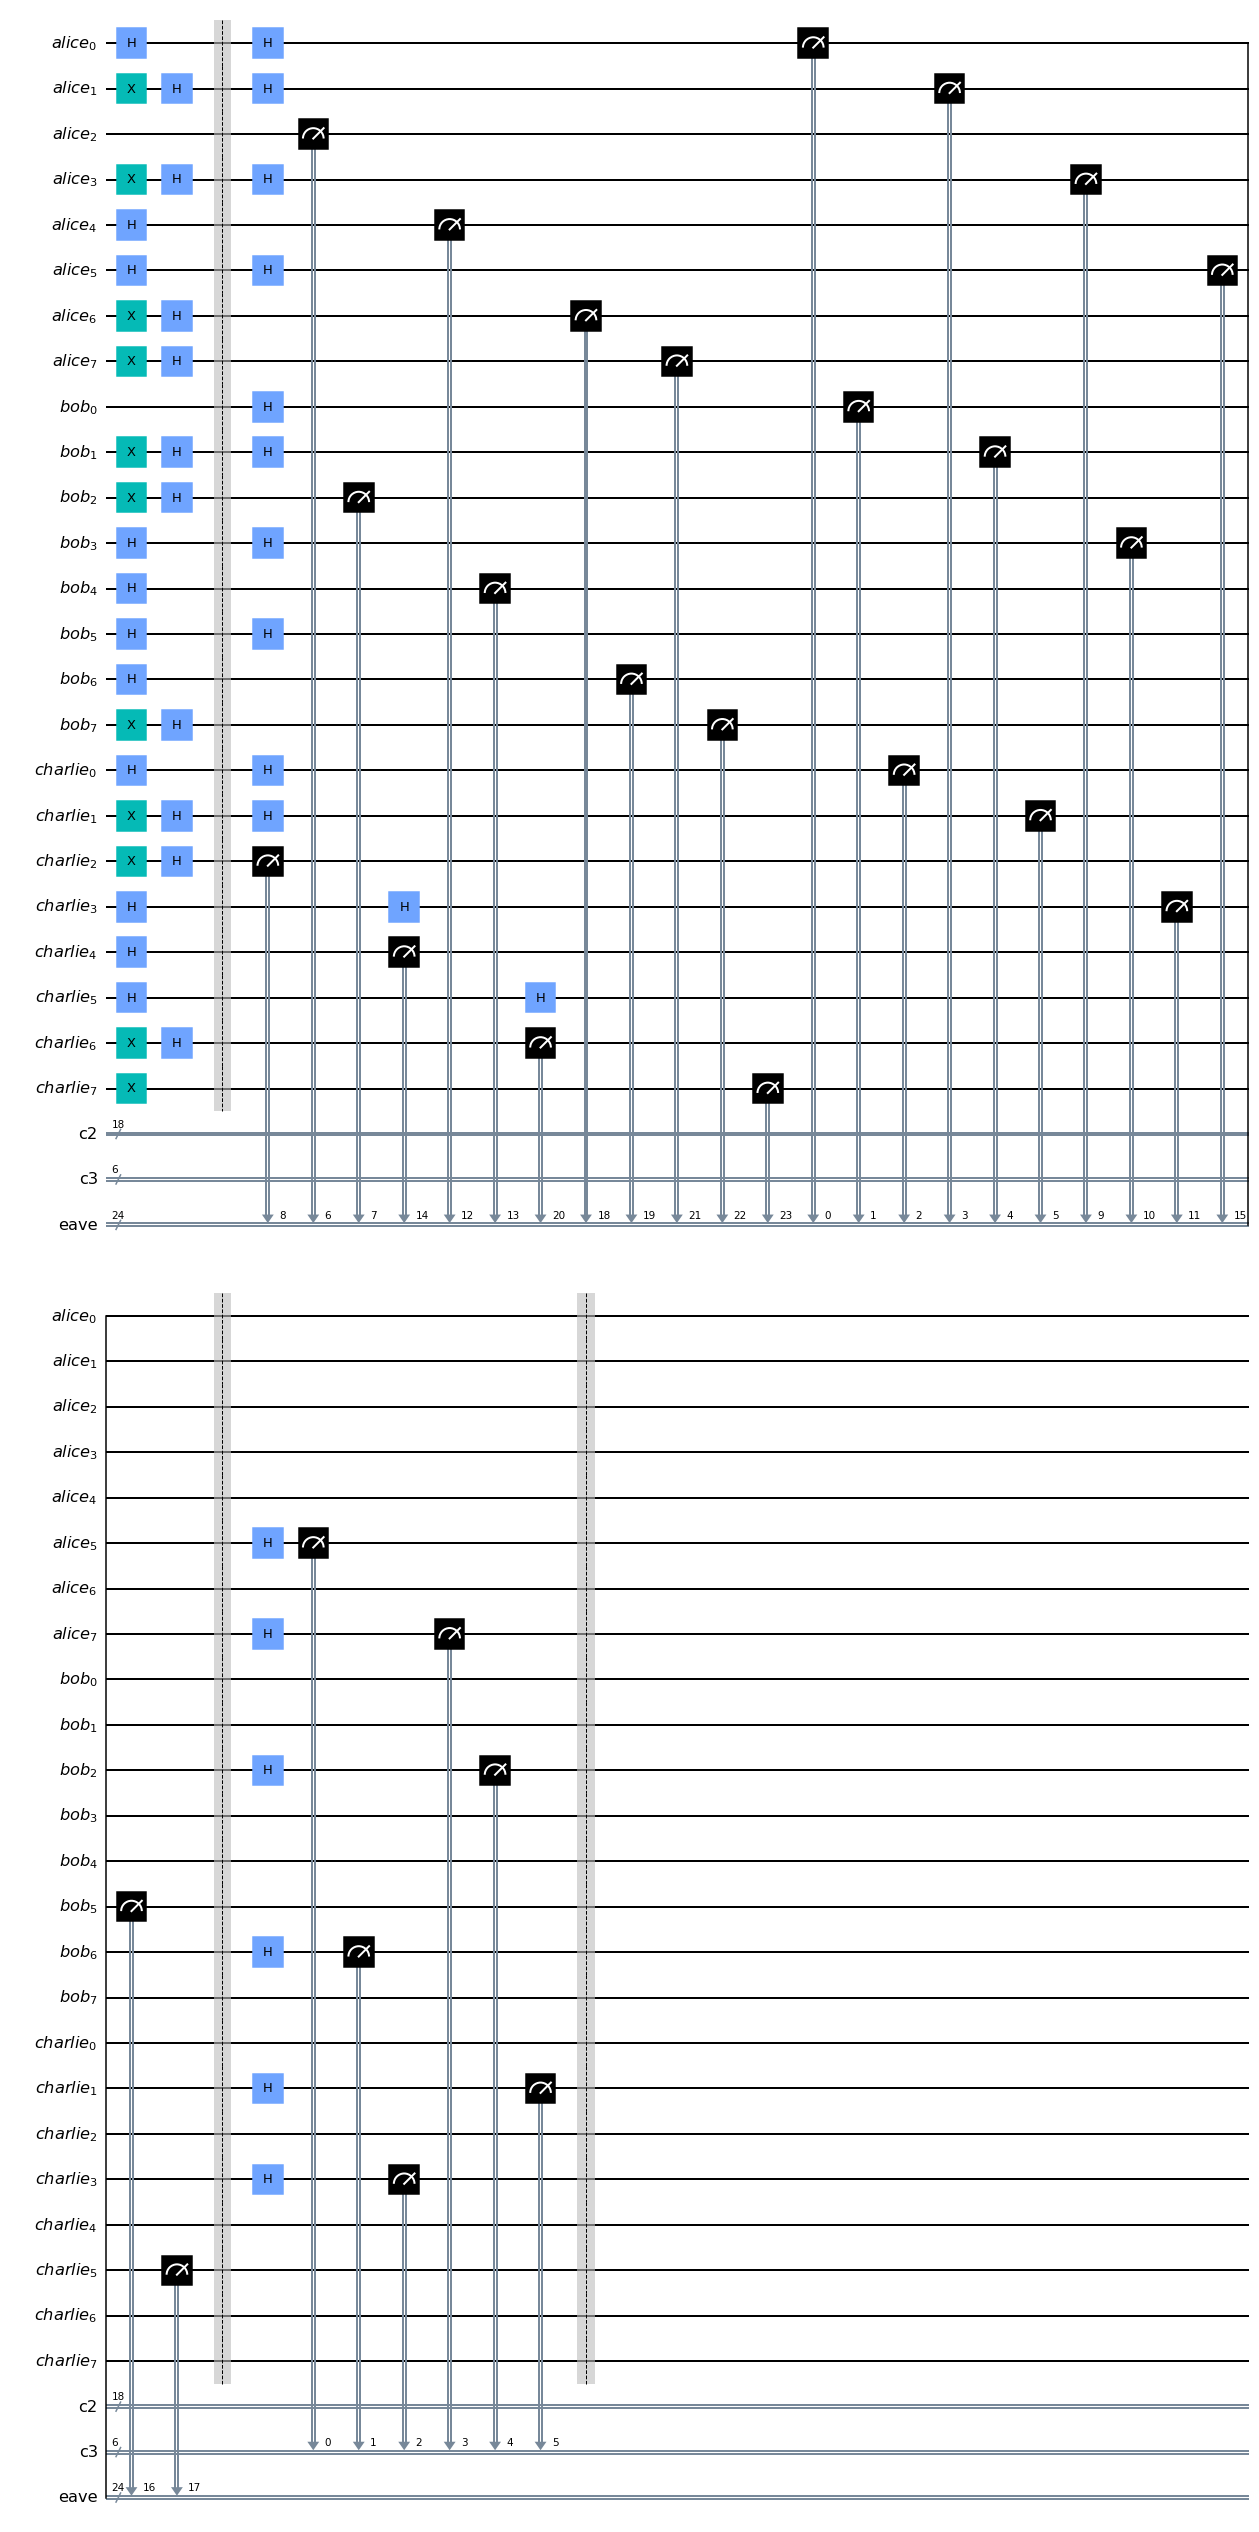

In [14]:
for i in range(delta_m):
    
    idx = common_idx[i]
    a_idx = qa_ini[idx]
    b_idx = qb_ini[idx]
    c_idx = qc_ini[idx] 
    
    k = key_ini[idx]

    if k == 1 :
        circuit.h([alice[a_idx], bob[b_idx], charlie[c_idx]])
    
    circuit.measure([alice[a_idx], bob[b_idx], charlie[c_idx]], [ufp2[3*i], ufp2[3*i+1], ufp2[3*i+2]])

circuit.barrier()

circuit.draw(output = "mpl")

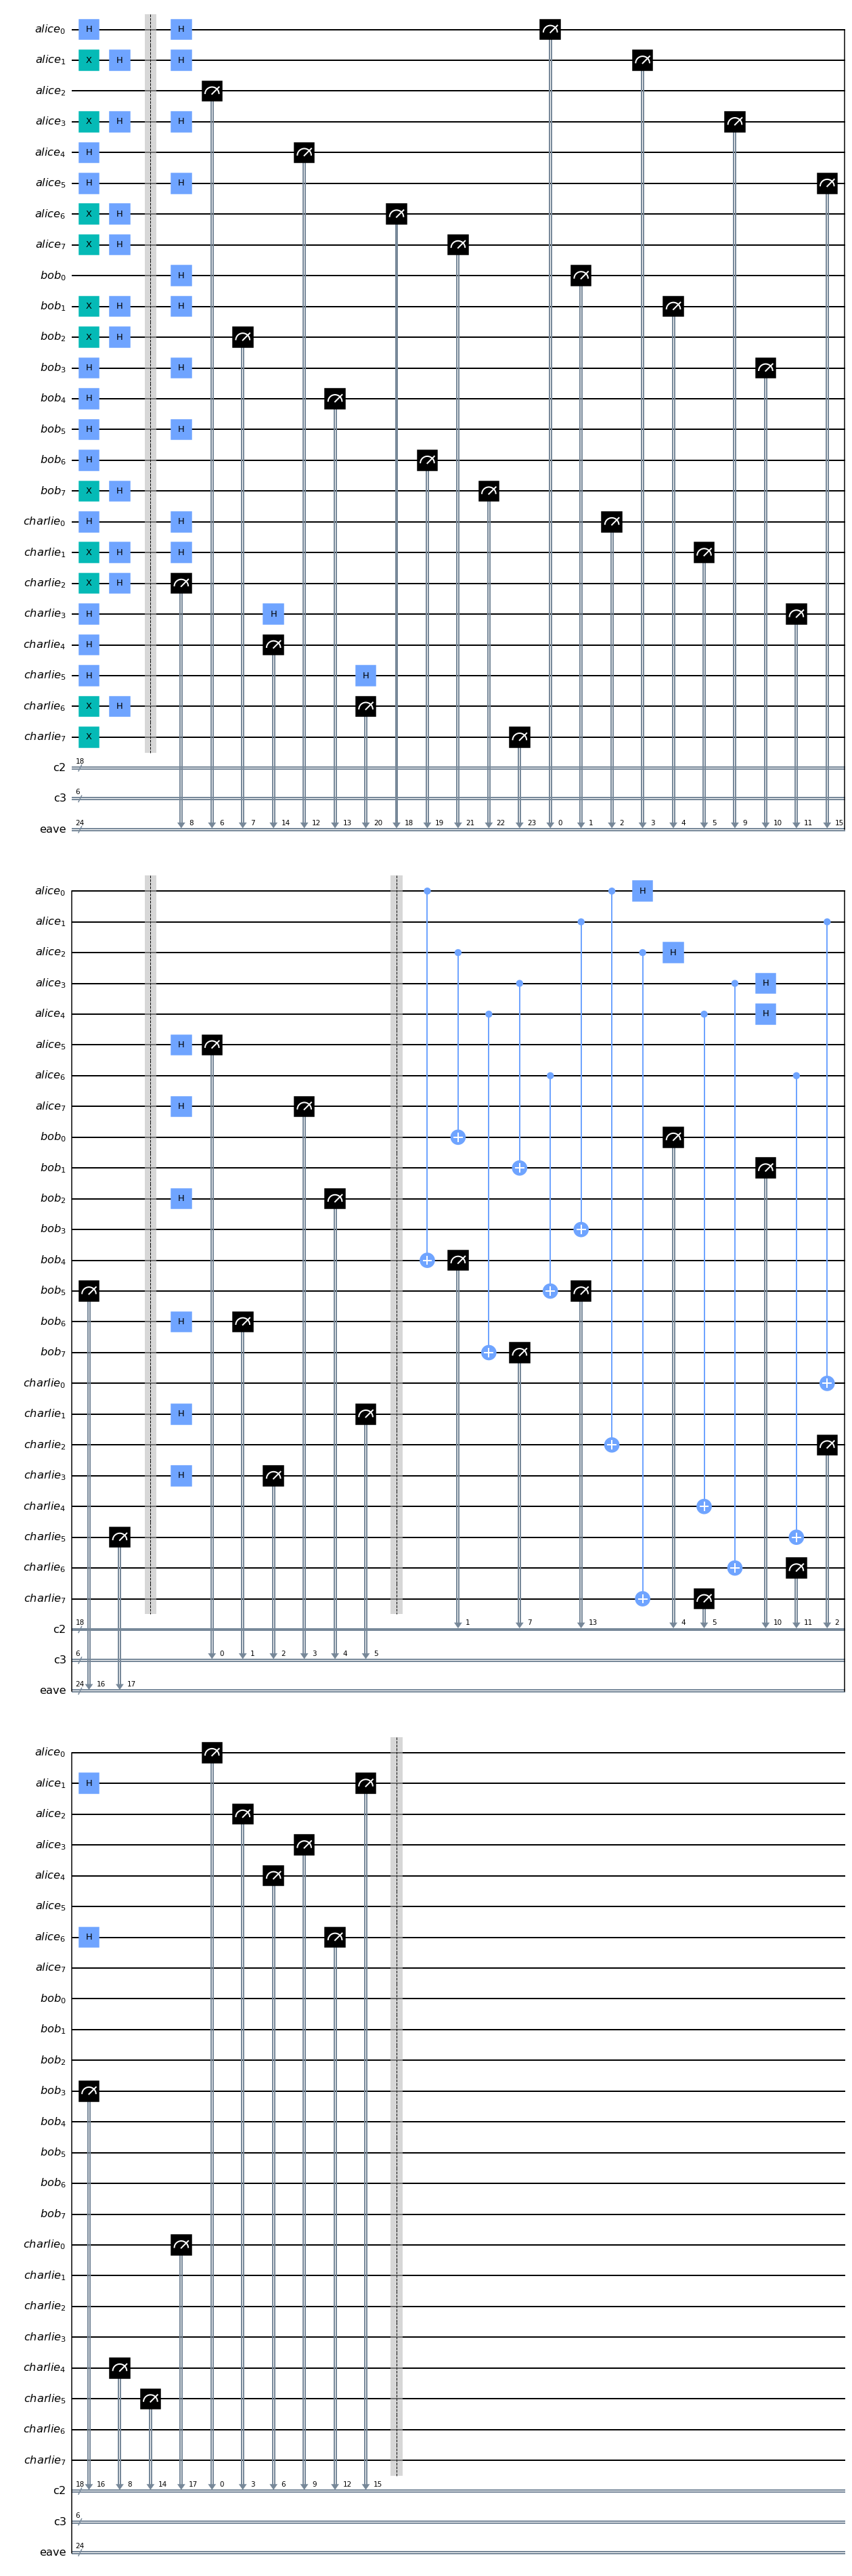

In [15]:
j = 0 

for i in range(num_bits):
    
    if i not in common_idx:
        
        a_idx = qa_ini[i]
        b_idx = qb_ini[i]
        c_idx = qc_ini[i]
            
        circuit.cx(alice[a_idx], bob[b_idx])
        circuit.cx(alice[a_idx], charlie[c_idx])
        circuit.h(alice[a_idx])
    
        circuit.measure([alice[a_idx], bob[b_idx], charlie[c_idx]], [ufp1[3*j], ufp1[3*j + 1], ufp1[3*j + 2]])
        j = j+1

circuit.barrier()
circuit.draw(output = "mpl")

In [52]:
detection = 0
totl = 0 

count = run_circuit(circuit, 2000)

r = count.items()
for res, shots in r:
    
    result = str(res)
    result = result[::-1]
#     print(result)
    decoy_res = result[3*(num_bits - delta_m) + 1: 3*num_bits + 1 ]
    
    for j in range(delta_m):
        
        a = (int)(decoy_res[3*j])
        b = (int)(decoy_res[3*j+1])
        c = (int)(decoy_res[3*j+2])
        
        idx = common_idx[j]
        
        a_mess = alice_mess_ini[idx]
        b_mess = bob_mess_ini[idx]
        c_mess = charlie_mess_ini[idx]
        
        totl = totl + shots
        if a != a_mess or b != b_mess or c != c_mess:
            detection = detection + shots

exp_prob = detection/totl
theory_prob = 1 - (3/4)**(3*delta_m)
# print(decoy_res)
print("The probability of Detecting Eave in the Channel is experimentally :" + str(exp_prob))
print("The probability of Detecting Eave in the Channel theoretically :" + str(theory_prob))

The probability of Detecting Eave in the Channel is experimentally :0.8835
The probability of Detecting Eave in the Channel theoretically :0.822021484375
